In [1]:
import pandas as pd
import numpy as np
import copy
import random
import math
from __future__ import division
from __future__ import with_statement
import minimization as minz #My script in same folder for minimization routines
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

Import all data available (very useful for any other plot)

In [2]:
n_rounds = 50
n_parents = 20

#Treatments and runs have to be the same lenght (one list per treatment)
n_signals_list = [0,0,1,1,0] #corresponding to each treatment in treatments (keep same order)
n_states_list = [8,8,8,8,8]
N_list = [40,40,40,40,40]
treatments = ['nosignal','nosignalsuperlong','signalce','signalcesuperlong','70to72k_nosignalsuperlong'] #outputmodifier+clue
runs = [[1,2,3,4,5,6],[1,2],[1,2,3,4,5],[1,2],[1,2]] #runs for each treatment. Each list has the runs to include for the corresponding treatment\
                         #(in same order as 'treatments')
info = {'summary':'summ','epochs_av':'ep', 'epochs_jm':'epj', 'jm':'jmachines'} #a shorter name for each type of data


folder = "/Users/luisalejandrolee/Dropbox/Thesis Phd/\
Coordination autos Chapter three/outputs_from_python/" #Python (minimization) outputs in this folder

folder_figs = "/Users/luisalejandrolee/Dropbox/Thesis Phd/Coordination autos Chapter three/figures_from_python/"
save_fig_type = '.png'
def import_epochs_epochsjm_jointmachines_summary(treatments, runs, info, folder,\
                                    n_states , n_signals, n_rounds, N, n_parents):
    
    data = {} #dictionary will contain all dataframes imported
    for pos,treatment in enumerate(treatments): #all treatments
        n_signals = n_signals_list[pos]
        n_states = n_states_list[pos]
        N = N_list[pos]
        for run in runs[pos]: #runs per treatment
            clue= treatment+str(run) #runs
            for info_name, info_variable in info.iteritems():#example: infoname=epochs_av, info_variable=ep
                
                inf = (info_name, clue, n_states , n_signals, n_rounds, N, n_parents)
                try:
                    import_file = folder+'%s_%s_states_%s_signal_%s_rounds_%s_N_%s_parents_%s.txt'%inf
                    #print import_file
                    df = pd.read_csv(import_file)
                    df = df.drop('Unnamed: 0',1)
                    data['%s%s_%s'%(treatments[pos], run, info_variable)] = df #add to dataframe to data dictionary

                    #print '%s%s_%s imported\n'%(treatments[pos], run, info_variable)
                except IOError:
                    pass
                    #print '%s%s_%s NOT FOUND. (File: %s\n'%(treatments[pos], run, info_variable, import_file)
    return data

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)
len(data)

50

#Total epochs and Frequency
Wrangle data for total epoch frequency 

In [3]:
#For panel 1
var = ['nosignalsuperlong2','signalcesuperlong2']
treatment_names = ['No Signal','Signal']
total_category = 'Total Epochs'

#Next loop saves in 'series' a list for each var. The latter contains (100,000 or the length of the run) dummies
#with 1 in position i, if generation i was an epoch change (zero otherwise)

series=[None]*len(var) #to store time series
for i,v in enumerate(var): #all vars selected
    name_sum='%s_summ'%v #name for retrieving imported data as data[name].Summ for summary
    name_ep='%s_ep'%v #ep for epochs
    
    ends = list(data[name_ep].end) #generations where an epoch ended
    length=len(data[name_sum].index) #length of one run
    
    dummy_ends = [1 if gen in ends else 0 for gen in xrange(1,length+1)] #1 if in that generation an epoch ends
    series[i]=dummy_ends #save in series list

#Concatenate series corresponding to each treatment, and store them in dataframe
df = pd.DataFrame({treatment_names[0]: series[0], treatment_names[1]: series[1]})

#Counts is main variable to plot
counts = df.mean()*len(df) #means*total gens (to show total number of epoch changes instead of very low percentages)

#Some arragements to count (which is a series). I prefer the plot as a dataframe, for aesthetic reasons.
counts_df = pd.DataFrame(counts).transpose() #index as columns
counts_df.index = [total_category]

#Confidence intervals
ci = stats.sem(df)*len(df) #get confidence interval at 95% assuming normal distribution

#Some arragements to count (which is a series). I prefer the plot as a dataframe, for aesthetic reasons.
ci_df = pd.DataFrame(ci).transpose() #index as columns
ci_df.index = [total_category]
ci_df.columns = [df.columns]


Wrangle data for frequency per regime

In [4]:
#For panel 2

#Organise data frame for frequency of epochs
#Two blocks of data, one for no signal(e.g. treatment 1) and the other for signal (e.g. treatment 2)
#Here is two runs per treatment. If wanna use only one run, replace one data with =[None]

ns =data['nosignalsuperlong2_ep'] #ns2=[None] to use only one data set (for reusability of code later)
s = data['signalcesuperlong2_ep']

title = 'Frequency of Epochs, Signal vs. No Signal\n2 runs of 100,000 generations per treatment'
panel1title='Frequency Percentage'
panel2title='Total Epoch changes'

######################################

#Have statistics by Domination and Biased, irrespective of whether is one population or the other dominating
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]

s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]


In [5]:

dum_ns = pd.get_dummies(ns['epoch']) #Dummies dataframe (categories are the regimes). One df per treatment
dum_s = pd.get_dummies(s['epoch'])

mean_ns = dum_ns.mean() #Mean of the dummies is what is plotted (i.e. percentage of each category)
mean_s = dum_s.mean()

ci_ns = stats.sem(dum_ns) #Standard error of the mean. For error bars
ci_s = stats.sem(dum_s)

means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s})#Get means in a single dataframe for easy plotting
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s})#get confidence interval in a single dataframe

ci.index=means.index[:] #very rough way to have the index for ci. Could be done better. Means and ci must have
                        #same index and in the same order at this point, so they correspond accordingly.

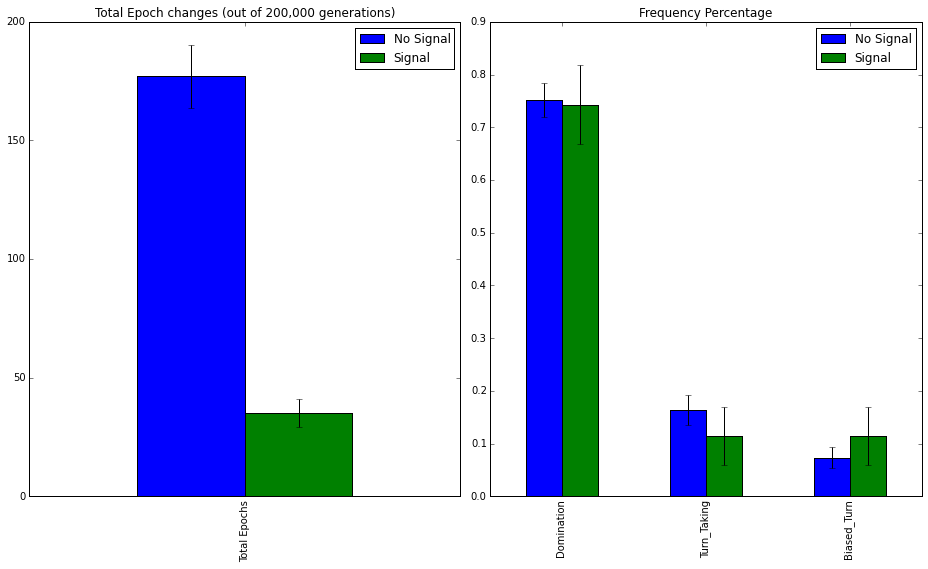

In [6]:
title = 'Frequency of Epochs\nOne long run (100,000 generations) per treatment'
panel1title='Total Epoch changes (out of 200,000 generations)'
panel2title='Frequency Percentage'

#Define plots
fig=plt.figure()


#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(13, 8) #size of the whole figure
ax1=plt.subplot(121)
plt.title(panel1title)
ax2=plt.subplot(122)
plt.title(panel2title)

counts_df.plot(kind='bar',yerr=ci_df,ax=ax1)#sorted means are plotted
means.drop('Other').sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax2)#sorted means are plotted

plt.tight_layout()
fig.savefig(folder_figs+'frequency_of_epochs'+save_fig_type, dpi = 100)

#Length of Epochs

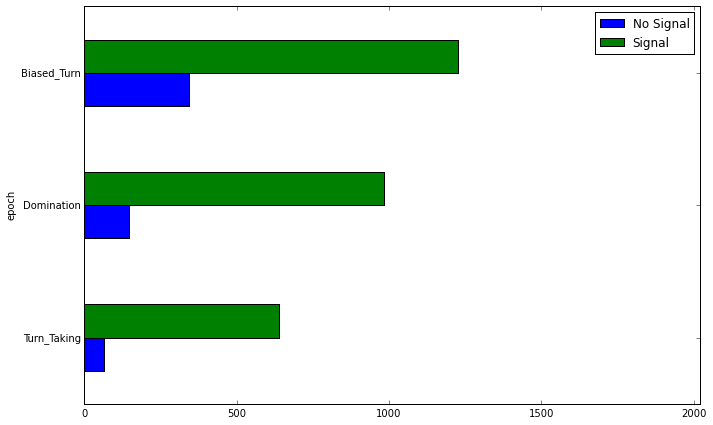

In [229]:
#Organise data frame for frequency of epochs
#Two blocks of data, one for no signal(e.g. treatment 1) and the other for signal (e.g. treatment 2)
#Here is two runs per treatment. If wanna use only one run, replace one data with =[None]

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns=data['nosignalsuperlong2_ep'] 
s = data['signalcesuperlong2_ep']

title = 'Length of Epochs per Regime\n2 runs of 100,000 generations per treatment'


######################################

#ns = ns1.append(ns2, ignore_index=True).drop(['start','end'],1) #Append datasets for the same treatment, dropping some columns
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]
#s = s1.append(s2, ignore_index=True)
s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]

#All this plot is the same as the one for frequencies percentages. The difference is next block:
#Instead of 'pivoting' the table to have a dummy for each category (as .get_dummy() does), here I use
#a normal pivoting to keep the values of 'duration'.
ns_p = pd.pivot_table(ns, index=ns.index, columns='epoch',values='duration').drop('Other',1)
s_p = pd.pivot_table(s, index=s.index, columns='epoch',values='duration').drop('Other',1)
#Replace NaN values with zero to calculate means
ns_p=ns_p.fillna(0)
s_p=s_p.fillna(0)
#######

mean_ns = ns_p.mean()
mean_s = s_p.mean()

ci_ns = stats.sem(ns_p)
ci_s = stats.sem(s_p)

means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s})
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s})#get confidence interval in a single dataframe
ci.index=means.index[:]

#Define plots
fig=plt.figure()
#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(10, 6) #size of the whole figure
ax1=plt.subplot(111)

#means.sort('No Signal').plot(kind='barh',xerr=ci,ax=ax1)#sorted means are plotted
means.sort('No Signal').plot(kind='barh',ax=ax1)#sorted means are plotted
ax1.set_xlim([0,2020])

plt.tight_layout()
fig.savefig(folder_figs+'length_of_epochs'+save_fig_type, dpi = 100)

#Probability of randomly choosing one generation, and it being each epoch

In [198]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns = data['nosignalsuperlong2_summ']['regime_av']
s = data['signalcesuperlong2_summ']['regime_av']

df = pd.DataFrame({'No signal':[],'Signal':[]})

In [204]:
df['ones_signal'] = [1]*len(ns)
df['ones_nosignal'] = [1]*len(ns)

In [207]:
df['No Signal'] = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
                   ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
                   for x in ns[:]]

df['Signal'] = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
                   ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
                   for x in s[:]]
df

,No signal,Signal,ones_signal,ones_nosignal,No Signal
0,Other,Other,1,1,Other
1,Other,Other,1,1,Other
2,Other,Other,1,1,Other
3,Domination,Other,1,1,Domination
4,Domination,Other,1,1,Domination
5,Domination,Other,1,1,Domination
6,Domination,Domination,1,1,Domination
7,Domination,Domination,1,1,Domination
8,Domination,Domination,1,1,Domination
9,Domination,Domination,1,1,Domination


In [209]:
a = df['ones_nosignal'].groupby(df['No Signal']).count()

No Signal
Biased_Turn    60923
Domination     26782
Other            680
Turn_Taking    11615
Name: ones_nosignal, dtype: int64

In [210]:
b = df['ones_signal'].groupby(df['Signal']).count()

Signal
Biased_Turn    42915
Domination     34538
Other            115
Turn_Taking    22432
Name: ones_signal, dtype: int64

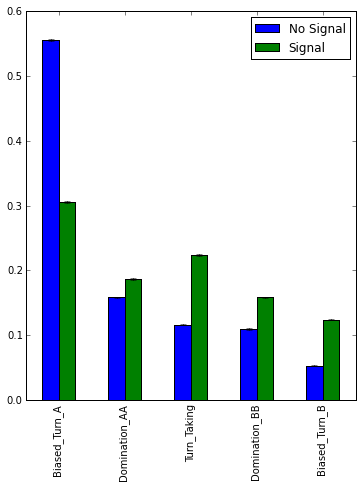

In [228]:
data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

ns = pd.DataFrame(data['nosignalsuperlong2_summ']['regime_av'])
ns.columns = ['epoch']
s = pd.DataFrame(data['signalcesuperlong2_summ']['regime_av'])
s.columns = ['epoch']
title = 'Prob of each epoch'

######################################

'''#ns = ns1.append(ns2, ignore_index=True).drop(['start','end'],1) #Append datasets for the same treatment, dropping some columns
ns.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in ns.epoch[:]]
#s = s1.append(s2, ignore_index=True)
s.epoch = ['Domination' if x=='Domination_AA' or x=='Domination_BB' else
           ('Biased_Turn' if x=='Biased_Turn_A' or x=='Biased_Turn_B' else x)
           for x in s.epoch[:]]'''

dum_ns = pd.get_dummies(ns['epoch']) #Dummies dataframe (categories are the regimes). One df per treatment
dum_s = pd.get_dummies(s['epoch'])

mean_ns = dum_ns.mean() #Mean of the dummies is what is plotted (i.e. percentage of each category)
mean_s = dum_s.mean()

ci_ns = stats.sem(dum_ns) #Standard error of the mean. For error bars
ci_s = stats.sem(dum_s)

means = pd.DataFrame({'No Signal': mean_ns, 'Signal': mean_s})#Get means in a single dataframe for easy plotting
ci = pd.DataFrame({'No Signal':ci_ns, 'Signal':ci_s})#get confidence interval in a single dataframe

ci.index=means.index[:] #very rough way to have the index for ci. Could be done better. Means and ci must have
                        #same index and in the same order at this point, so they correspond accordingly.
fig=plt.figure()


#fig.suptitle(title,fontsize=20)
plt.subplots_adjust(top=0.8)
fig.set_size_inches(13, 8) #size of the whole figure
ax1=plt.subplot(121)
means.drop('Other').sort('No Signal', ascending=False).plot(kind='bar',yerr=ci,ax=ax1)#sorted means are plotted

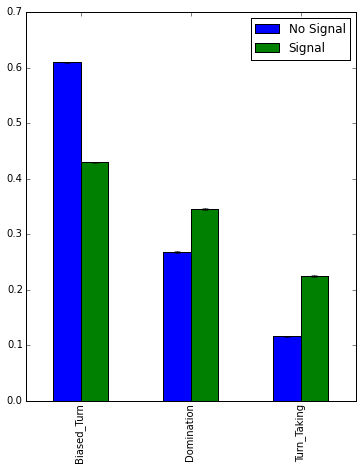

#CE Measure

In [39]:
#Can only use the second super long run because the first one has a bug: name 'ce' is ' ce' (I think 
#that's the bug, but couldn't trace it down). So would have to run
#one new simulation (superlong) to have two sims. One should do fine

data = import_epochs_epochsjm_jointmachines_summary(treatments, runs, info,\
                                                    folder, n_states_list , n_signals_list, n_rounds, N_list, n_parents)

summ =data['signalcesuperlong2_summ'] 
ep = data['signalcesuperlong2_ep']

#Add the 'ce' column to epochs dataframe, containing the average CE for that particular epoch
ce_list = []
for i in ep.index[:]:
    start = int(ep['start'][i])
    end = int(ep['end'][i])
    ce_range = summ['ce'][start:end]
    ce_list.append(ce_range.mean())
ep['ce'] = ce_list

#"see", or filter to observe how many turntaking were there, with their corresponding ce measure
#go and run a couple of gens for those epochs to get the joint machines

In [40]:
ep[(ep.epoch!='Domination_AA') & (ep.epoch!='Domination_BB') & (ep.epoch!='Other')]

,epoch,duration,start,end,ce
4,Biased_Turn_A,25617,2774,28391,0.112274
14,Biased_Turn_B,2762,37080,39842,0.233776
16,Biased_Turn_B,9590,44621,54211,0.405229
18,Turn_Taking,936,58637,59573,0.124782
20,Turn_Taking,5326,60856,66182,0.125341
25,Turn_Taking,7336,70877,78213,0.884996
27,Turn_Taking,8733,78556,87289,0.853684
34,Biased_Turn_A,4936,95064,100000,0.401399


In [41]:
ep

,epoch,duration,start,end,ce
0,Domination_BB,1128,13,1141,0.001572
1,Domination_BB,28,1152,1180,0.025903
2,Domination_BB,1550,1191,2741,0.000858
3,Other,17,2750,2767,0.081688
4,Biased_Turn_A,25617,2774,28391,0.112274
5,Domination_BB,57,28406,28463,0.005440
6,Domination_AA,178,28476,28654,0.001988
7,Domination_BB,115,28666,28781,0.001209
8,Domination_AA,22,28790,28812,0.002914
9,Domination_BB,35,28821,28856,0.002748


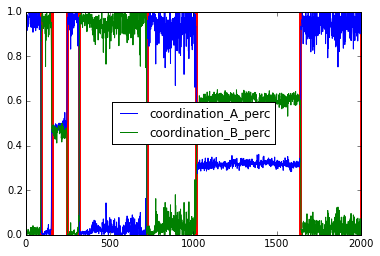

In [9]:
data['nosignal6_summ'][['coordination_A_perc','coordination_B_perc']].plot()
h_values = data['nosignal6_ep']['end']
for v in h_values:
    plt.vlines(v,0,1,linewidth=3, color='r')

In [ ]:
#Useful lines (not part of the code, but just to copy easily)

#Basic for a plot
data=[3,2,10]
fig,ax=plt.subplots(2,2,squeeze=False,sharex=True,sharey=Ture)
ax[0][0].plot(data)
ax[1][1].plot(data)
plt.close()



plt.vlines(x, ymin, ymax) #horizontal and vertical lines
plt.hlines(y, xmin, xmax)

#ax is the name of the plot. If used fig, axes = plt.subplot(2,2) to create several, they can be indexed
ax.set_yscale('log') #some regularly useful 'set' functions
ax.set_xlim([0,10])
ax.set_xlabel('some label')

fig.tight_layout() #avoids overlapping of axis ticks

#small code for adding several vertical lines in a particular plot (first make the relevant figure to be current)
h_values = [200, 300, 400]
for v in h_values:
    axes[0][0].vlines(v,0,3,linewidth=5, color='r')

axes[0][0].set_title('5 Simulations, No signal')
axes[0][0].set_xlabel('Generations')
axes[0][0].set_ylabel('Average Payoffs')

#To save
plt.savefig('foo.png', bbox_inches='tight')
fig.savefig('path/to/save/image/to.png')
